In [142]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [160]:
seed = 12132707
np.random.seed(seed)

In [3]:
survey_df = pd.concat([pd.read_csv("data/processed/ProcessedSurveyDataWithID_%d.csv" % i) for i in range(2020,2023)])

In [4]:
SURVEY_YEAR = "SurveyYear"
TITLE = "CurrentTitle"

In [5]:
survey_df.loc[survey_df["CurrentTitle"].isin(["Machine Learning/ MLops Engineer", "Machine Learning Engineer"]), "CurrentTitle"] = "Machine Learning Engineer"
survey_df.loc[survey_df["CurrentTitle"].isin(["Data Analyst", "Business Analyst", "Data Analyst (Business, Marketing, Financial, Quantitative, etc)"]), "CurrentTitle"] = "Data Analyst"

In [6]:
CLASSES = ["Research Scientist", "Data Scientist", "Data Analyst", "Machine Learning Engineer", "Data Engineer"]
CLASSES_FILTER = survey_df[TITLE].isin(CLASSES)

In [7]:
def year_filter(years=[2022]):
    return survey_df[SURVEY_YEAR].isin(years)

## Feature Engineering
- Age (Numeric?)
- Country (Categorical)
- MOOCLearning (#Platforms used - Numeric)
- UniversityCourse (bool)
- Highest Education (Cat)
- Research (Should use only 2022 data for this ?) - Figure out
- Programming Experience (Numeric)
- PythonUsed?
- SQL Used?
- R Used?
- Number of Programming Languages used (numeric)
- IDEs Used
- #HostedNBsUsed
- VizInPython
- VizInR
- #VizLibraries
- ML Exposure
- MLFrameworks
- #CV ALgos
- #NLP Algos
- TransferLearningDegree
- InvestmentInML
- AWS
- GCP
- Azure
- #CloudProviders
- ExperienceWithCloudCompute
- ExperienceWithCloudStorage
- ExperienceWithRelationalDB
- ExperienceWithNonRelationalDB
- ExperienceWithBITools
- PowerBI
- Tableau
- ExperienceWithMLaas
- ExperienceWithAutoML
- ExperienceWithMLDeploymentTools
- ExperienceWithMLMonitoringTools
- ResponsibleAI
- GPUUsed
- TPUUsageFrequecy
- ExperienceWithSpecializedhardware
- EngagementWithDSMedia
- ExperiencePipelineAutomation

#### Helper Functions

In [8]:
def get_col_names(df, include_kws, exclude_kws=None):
    """
    Return the column names that match any of include_kw and none of the exclude_kw
    """
    res_cols = []
    for col in df.columns:
        inc = False
        for include_kw in include_kws:
            inc = inc or (include_kw in col)
        exc = False
        if exclude_kws:
            for exclude_kw in exclude_kws:
                exc = exc or (exclude_kw in col)
        if inc and (not exc):
            res_cols.append(col)
    return res_cols

In [9]:
def add_col_to_df1(df1, df2, col_name, new_col_name, identifier="PID"):
    res = pd.merge(df1, df2[[identifier, col_name]], on=identifier, how="inner")
    res = res.rename({col_name: new_col_name}, axis=1)
    return res

In [10]:
def get_frequency_feature_in_df1(df1, df2, cols, new_col_name, identifier="PID"):
    df2 = df2.copy()
    df2["AggCol"] = df2[cols].sum(axis=1)
    res = add_col_to_df1(df1, df2[[identifier, "AggCol"]], "AggCol", new_col_name)
    del df2
    return res

#### Convert Age to Ordinal

In [11]:
enc_age = OrdinalEncoder(categories=[np.sort(survey_df["Age"].unique())])
survey_df["Age_categ"] = enc_age.fit_transform(survey_df["Age"].to_numpy().reshape(-1,1))
survey_df = survey_df.drop("Age", axis=1)

/var/folders/07/r04lbdjd0vj2ps53pqkc0b040000gn/T/ipykernel_1115/1204961570.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey_df["Age_categ"] = enc_age.fit_transform(survey_df["Age"].to_numpy().reshape(-1,1))


In [12]:
survey_df

,Unnamed: 0,Duration (in seconds),Gender,Country,IsStudent,MOOCPlatforms_Coursera,MOOCPlatforms_edX,MOOCPlatforms_Kaggle Learn Courses,MOOCPlatforms_DataCamp,MOOCPlatforms_Fast.ai,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,PID,Age_categ
0,49970,1838,Man,Colombia,Yes,1,0,1,0,0,...,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,1_2020,4.0
1,49971,289287,Man,United States of America,No,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_2020,3.0
2,49972,860,Man,Argentina,No,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3_2020,4.0
3,49973,507,Man,United States of America,No,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_2020,3.0
4,49974,78,Man,Japan,No,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_2020,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23992,23992,331,Man,United States of America,Yes,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23992_2022,1.0
23993,23993,330,Man,United States of America,Yes,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23993_2022,9.0
23994,23994,860,Man,Turkey,No,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23994_2022,2.0
23995,23995,597,Woman,Israel,No,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23995_2022,4.0


In [13]:
adf = survey_df.loc[CLASSES_FILTER, ["PID", TITLE, "Age_categ", "Country"]]

In [14]:
CATEGORICAL_FEATURES = []
BINARY_FEATURES = []
NUMERICAL_FEATURES = ["Age_categ"]

In [15]:
country_cluster_mapping = {
    "AsianFuture": ['Russia', 'Egypt', 'Viet Nam', 'India', 'China', 'Nigeria', 'Pakistan', 'Indonesia', 'Bangladesh', 'Morocco', 'Iran, Islamic Republic of...', 'Tunisia'],
    "DevelopedGuards" : ['Portugal', 'Israel', 'United Kingdom of Great Britain and Northern Ireland', 'Italy', 'Spain', 'Canada', 'Australia', 'United States of America', 'Poland', 'France', 'Germany', 'Netherlands', 'United Arab Emirates', 'Japan'],
    "SouthAmericaAndOthers": ['Peru', 'Colombia', 'South Africa', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Turkey', 'Thailand', 'Taiwan', 'South Korea', 'Saudi Arabia', 'Philippines']
}

In [16]:
def get_country_cluster(country):
    for key in country_cluster_mapping.keys():
        if country in country_cluster_mapping[key]:
            return key
    return "Others"

In [17]:
get_country_cluster("Peru")

'SouthAmericaAndOthers'

In [18]:
adf["CountryClusters"] = adf["Country"].apply(lambda x:get_country_cluster(x))

In [20]:
CATEGORICAL_FEATURES.append("CountryClusters")

<center> Feature: <b>MOOC Learning Platforms</b> </center>

In [21]:
adf = add_col_to_df1(adf, survey_df, "MOOCPlatforms_University Courses (resulting in a university degree)", "CompletedUniDegree")

In [22]:
MOOC_COLS = get_col_names(survey_df, include_kws=["MOOCPlatforms_"], exclude_kws=["Other", "None"])

In [23]:
adf = get_frequency_feature_in_df1(adf, survey_df, MOOC_COLS, "NumCoursePlatforms")

In [24]:
BINARY_FEATURES.append("CompletedUniDegree")
NUMERICAL_FEATURES.append("NumCoursePlatforms")

<center> Feature: <b>Highest Education (Ordinal - Treated as numeric)</b> </center>

In [26]:
adf = add_col_to_df1(adf, survey_df, "HighestEducation", "HighestEducation")

In [27]:
enc = OrdinalEncoder(categories=[["Other", "Lower than Bachelor", "Bachelor", "Master", "Higher than Master"]])
adf["EduOrdinal"] = enc.fit_transform(adf["HighestEducation"].to_numpy().reshape(-1,1))

In [28]:
NUMERICAL_FEATURES.append("EduOrdinal")

<center> Feature: <b>Programming Experience (Ordinal - Treated as Numeric)</b> </center>

In [30]:
adf = add_col_to_df1(adf, survey_df, "Programming Experience", "Programming Experience")

In [31]:
adf["Programming Experience"] = adf["Programming Experience"].fillna('I have never written code')

In [32]:
enc = OrdinalEncoder(categories=[['I have never written code', '< 1 years', '1-2 years', '1-3 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']])
adf["ProgExpOrdinal"] = enc.fit_transform(adf["Programming Experience"].to_numpy().reshape(-1,1))

In [33]:
NUMERICAL_FEATURES.append("ProgExpOrdinal")

<center> Feature: <b>Programming Languages</b> </center>

In [35]:
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_Python", "UsedPython")
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_R", "UsedR")
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_SQL", "UsedSQL")

In [36]:
BINARY_FEATURES.extend(["UsedPython", "UsedR", "UsedSQL"])

In [37]:
PROGLANG_COLS = get_col_names(survey_df, include_kws=["ProgLanguage_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, PROGLANG_COLS, "NumProgLanguages")

In [38]:
NUMERICAL_FEATURES.append("NumProgLanguages")

<center> Feature: <b>Visualization Experience</b> </center>

In [40]:
PYTHON_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_Altair", "VizLib_Bokeh", "VizLib_Geoplotlib", "VizLib_Matplotlib", "VizLib_Plotly", "VizLib_Seaborn", "VizLib_Pygal"], exclude_kws=["Other", "None"])
JS_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_D3 js"], exclude_kws=["Other", "None"])
R_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_Dygraphs", "VizLib_Ggplot", "VizLib_Highchart", "VizLib_Shiny"], exclude_kws=["Other", "None"])

In [41]:
survey_df["PyVizUsage"] = survey_df[PYTHON_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["PyVizUsage"]>1, "PyVizUsage"] = 1

survey_df["RVizUsage"] = survey_df[R_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["RVizUsage"]>1, "RVizUsage"] = 1

survey_df["JSVizUsage"] = survey_df[JS_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["JSVizUsage"]>1, "JSVizUsage"] = 1

In [42]:
adf = add_col_to_df1(adf, survey_df, "PyVizUsage", "UsedPyViz")
adf = add_col_to_df1(adf, survey_df, "RVizUsage", "UsedRViz")
adf = add_col_to_df1(adf, survey_df, "JSVizUsage", "UsedJSViz")

In [43]:
BINARY_FEATURES.extend(["UsedPyViz", "UsedRViz", "UsedJSViz"])

In [44]:
BINARY_FEATURES

['CompletedUniDegree',
 'UsedPython',
 'UsedR',
 'UsedSQL',
 'UsedPyViz',
 'UsedRViz',
 'UsedJSViz']

<center> Feature: <b>ML Exposure</b> </center>

In [45]:
adf = add_col_to_df1(adf, survey_df, "MLExposure", "MLExposure")
adf["MLExposure"] = adf["MLExposure"].fillna('I do not use machine learning methods')

enc = OrdinalEncoder(categories=[['I do not use machine learning methods', 'Under 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years']])
adf["MLExpOrdinal"] = enc.fit_transform(adf["MLExposure"].to_numpy().reshape(-1,1))

In [46]:
adf["MLExposure"].unique()

array(['1-2 years', '3-4 years', 'I do not use machine learning methods',
       '2-3 years', 'Under 1 year', '4-5 years', '5-10 years',
       '20 or more years', '10-20 years'], dtype=object)

In [47]:
NUMERICAL_FEATURES.append("MLExpOrdinal")

<center> Feature: <b>ML Frameworks</b> </center>

In [49]:
get_col_names(survey_df, include_kws=["MLFramework"])

['MLFramework_Scikit-learn',
 'MLFramework_TensorFlow',
 'MLFramework_Keras',
 'MLFramework_PyTorch',
 'MLFramework_Fast.ai',
 'MLFramework_Xgboost',
 'MLFramework_LightGBM',
 'MLFramework_CatBoost',
 'MLFramework_Caret',
 'MLFramework_Tidymodels',
 'MLFramework_JAX',
 'MLFramework_PyTorch Lightning',
 'MLFramework_Huggingface',
 'MLFramework_None',
 'MLFramework_Other',
 'MLFramework_MXNet',
 'MLFramework_Prophet',
 'MLFramework_H2O 3',
 'AutoMLFrameworksUsed_Automated data augmentation (e.g. imgaug, albumentations)',
 'AutoMLFrameworksUsed_Automated feature engineering/selection (e.g. tpot, boruta_py)',
 'AutoMLFrameworksUsed_Automated model selection (e.g. auto-sklearn, xcessiv)',
 'AutoMLFrameworksUsed_Automated model architecture searches (e.g. darts, enas)',
 'AutoMLFrameworksUsed_Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)',
 'AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H2O Driverless AI)',
 'AutoMLFrameworksUsed_No / None',
 '

In [50]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Scikit-learn", "UsedSKlearn")

In [51]:
survey_df["TFKerasUsage"] = survey_df[['MLFramework_TensorFlow','MLFramework_Keras']].fillna(0).sum(axis=1)
survey_df.loc[survey_df["TFKerasUsage"]>1, "TFKerasUsage"] = 1
adf = add_col_to_df1(adf, survey_df, "TFKerasUsage", "UsedTFKeras")

In [52]:
survey_df["PyTorchUsage"] = survey_df[['MLFramework_PyTorch','MLFramework_PyTorch Lightning']].fillna(0).sum(axis=1)
survey_df.loc[survey_df["PyTorchUsage"]>1, "PyTorchUsage"] = 1
adf = add_col_to_df1(adf, survey_df, "PyTorchUsage", "UsedPyTorch")

In [53]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Huggingface", "UsedHF")

In [54]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Fast.ai", "UsedFastAI")

In [55]:
BINARY_FEATURES.extend(["UsedSKlearn", "UsedTFKeras", "UsedPyTorch", "UsedHF", "UsedFastAI"])

In [56]:
MLFRAMEWORK_COLS = get_col_names(survey_df, include_kws=["MLFramework_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, MLFRAMEWORK_COLS, "NumMLFrameworks")

In [57]:
NUMERICAL_FEATURES.append("NumMLFrameworks")

<center> Feature: <b>ML Algorithms</b> </center>

In [58]:
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Linear or Logistic Regression", "UsedLinearModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Decision Trees or Random Forests", "UsedTreeModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Gradient Boosting Machines (xgboost, lightgbm, etc)", "UsedGBModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Bayesian Approaches", "UsedBayesianModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Evolutionary Approaches", "UsedEvolutionaryModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Dense Neural Networks (MLPs, etc)", "UsedNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Convolutional Neural Networks", "UsedCNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Generative Adversarial Networks", "UsedGANModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Transformer Networks (BERT, gpt-3, etc)", "UsedTransformerModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Autoencoder Networks (DAE, VAE, etc)", "UsedAEModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Recurrent Neural Networks", "UsedRNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Graph Neural Networks", "UsedGraphModels")

In [59]:
MLALGOCOLS = get_col_names(survey_df, include_kws=["MLAlgo_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, MLALGOCOLS, "NumMLAlgos")

In [60]:
BINARY_FEATURES.extend(["UsedLinearModels","UsedTreeModels","UsedGBModels","UsedBayesianModels","UsedEvolutionaryModels","UsedNNModels","UsedCNNModels","UsedGANModels","UsedTransformerModels","UsedAEModels","UsedRNNModels","UsedGraphModels"])
NUMERICAL_FEATURES.extend(["NumMLAlgos"])

<center> Feature: <b>Transfer Learning</b> </center>

In [61]:
PRETRAINED_COLS = get_col_names(survey_df, include_kws=["DownloadPreTrainedWeights_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, PRETRAINED_COLS, "NumTransferLearning")

In [62]:
NUMERICAL_FEATURES.append("NumTransferLearning")

<center> Feature: <b>CloudProviders</b> </center>

In [64]:
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Google Cloud Platform (GCP)", "UsedGCP")
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Amazon Web Services (AWS)", "UsedAWS")
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Microsoft Azure", "UsedAzure")

In [65]:
BINARY_FEATURES.extend(["UsedGCP", "UsedAWS", "UsedAzure"])

In [66]:
CLOUDPROVIDER_COLS = get_col_names(survey_df, include_kws=["CloudProviderUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDPROVIDER_COLS, "NumCloudProvidersUsed")

In [67]:
NUMERICAL_FEATURES.append("NumCloudProvidersUsed")

<center> Feature: <b>CloudCompute</b> </center>

In [68]:
CLOUDCOMPUTE_COLS = get_col_names(survey_df, include_kws=["CloudComputeUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDCOMPUTE_COLS, "NumCloudComputeUsed")
NUMERICAL_FEATURES.append("NumCloudComputeUsed")

<center> Feature: <b>CloudStorage</b> </center>

In [69]:
CLOUDSTORAGE_COLS = get_col_names(survey_df, include_kws=["CloudStorageUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDSTORAGE_COLS, "NumCloudStorageUsed")
NUMERICAL_FEATURES.append("NumCloudStorageUsed")

<center> Feature: <b>DBUSed</b> </center>

In [70]:
get_col_names(survey_df, include_kws=["DBUsed_"], exclude_kws=["Other", "None"])

['DBUsed_MySQL',
 'DBUsed_PostgreSQL',
 'DBUsed_SQLite',
 'DBUsed_Oracle Database',
 'DBUsed_MongoDB',
 'DBUsed_Snowflake',
 'DBUsed_IBM Db2',
 'DBUsed_Microsoft SQL Server',
 'DBUsed_Microsoft Azure SQL Database',
 'DBUsed_Amazon Redshift',
 'DBUsed_Amazon RDS',
 'DBUsed_Amazon DynamoDB',
 'DBUsed_Google Cloud BigQuery',
 'DBUsed_Google Cloud SQL',
 'DBUsed_Microsoft Azure Cosmos DB',
 'DBUsed_Amazon Aurora',
 'DBUsed_Google Cloud Firestore',
 'DBUsed_Google Cloud BigTable',
 'DBUsed_Google Cloud Spanner',
 'DBUsed_PostgresSQL',
 'DBUsed_Microsoft Access',
 'DBUsed_Microsoft Azure Data Lake Storage',
 'DBUsed_Amazon Athena']

In [71]:
def get_db_type(db):
    for key in rel_db_map.keys():
        if db in rel_db_map[key]:
            return key
    return "Others"

In [72]:
RELATIONAL_DBS = ["DBUsed_Microsoft Access","DBUsed_Google Cloud Spanner","DBUsed_Amazon Aurora","DBUsed_Microsoft Azure Cosmos DB","DBUsed_Google Cloud SQL","DBUsed_Google Cloud BigQuery","DBUsed_Amazon RDS","DBUsed_Amazon Redshift","DBUsed_Snowflake", "DBUsed_IBM Db2", "DBUsed_Microsoft SQL Server", "DBUsed_Microsoft Azure SQL Database","DBUsed_MySQL", "DBUsed_PostgreSQL", "DBUsed_PostgresSQL", "DBUsed_SQLite", 'DBUsed_Oracle Database']
NON_RELATIONAL_DBS = ["DBUsed_Google Cloud BigTable","DBUsed_Google Cloud Firestore","DBUsed_Microsoft Azure Cosmos DB","DBUsed_Amazon DynamoDB","DBUsed_MongoDB"]

In [73]:
survey_df["UsedRelationalDBs"] = survey_df[RELATIONAL_DBS].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)
survey_df["UsedNonRelationalDBs"] = survey_df[NON_RELATIONAL_DBS].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [74]:
adf = add_col_to_df1(adf, survey_df, "UsedRelationalDBs", "UsedRelationalDBs")
adf = add_col_to_df1(adf, survey_df, "UsedNonRelationalDBs", "UsedNonRelationalDBs")

In [75]:
BINARY_FEATURES.extend(["UsedRelationalDBs","UsedNonRelationalDBs"])

<center> Feature: <b>BI Tools</b> </center>

In [76]:
survey_df["UsedTableau"] = survey_df[["BIToolUsed_Tableau", "BIToolUsed_Tableau CRM"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [77]:
adf = add_col_to_df1(adf, survey_df, "BIToolUsed_Microsoft Power BI", "UsedPowerBI")
adf = add_col_to_df1(adf, survey_df, "UsedTableau", "UsedTableau")

In [78]:
BINARY_FEATURES.extend(["UsedPowerBI","UsedTableau"])

In [79]:
BI_COLS = get_col_names(survey_df, include_kws=["BIToolUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, BI_COLS, "NumBIToolsUsed")

In [80]:
NUMERICAL_FEATURES.append("NumBIToolsUsed")

<center> Features: <b>MLaaS, AutoML, Deployment, Monitoring Tools</b> </center>

In [81]:
COLS = get_col_names(survey_df, include_kws=["MLaaS_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLaaSToolsUsed")
NUMERICAL_FEATURES.append("NumMLaaSToolsUsed")

In [82]:
COLS = get_col_names(survey_df, include_kws=["AutoMLUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumAutoMLUsed")
NUMERICAL_FEATURES.append("NumAutoMLUsed")

In [83]:
COLS = get_col_names(survey_df, include_kws=["MLDeploymentToolsUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLDeploymentToolsUsed")
NUMERICAL_FEATURES.append("NumMLDeploymentToolsUsed")

In [84]:
COLS = get_col_names(survey_df, include_kws=["MLMonitoringToolUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLMonitoringToolUsed")
NUMERICAL_FEATURES.append("NumMLMonitoringToolUsed")

<center> Feature: <b>Hardware</b> </center>

In [85]:
survey_df["UsedGPU"] = survey_df[["HardwareUsed_GPUs", "HardwareUsed_NVIDIA GPUs"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [86]:
adf = add_col_to_df1(adf, survey_df, "UsedGPU", "UsedGPU")

In [87]:
BINARY_FEATURES.extend(["UsedGPU"])

In [88]:
adf = add_col_to_df1(adf, survey_df, "TPUUsageFrequency", "TPUUsageFrequency")

In [89]:
adf["TPUUsageFrequency"] = adf["TPUUsageFrequency"].fillna('Never')

enc = OrdinalEncoder(categories=[['Never', 'Once', '2-5 times', '6-25 times', 'More than 25 times']])
adf["TPUUsageOrdinal"] = enc.fit_transform(adf["TPUUsageFrequency"].to_numpy().reshape(-1,1))

In [90]:
COLS = get_col_names(survey_df, include_kws=["HardwareUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumHardwareUsed")
NUMERICAL_FEATURES.append("NumHardwareUsed")

In [91]:
NUMERICAL_FEATURES.append("TPUUsageOrdinal")

<center> Feature: <b>DSMedia</b> </center>

In [92]:
COLS = get_col_names(survey_df, include_kws=["DSContentMediaConsumed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumDSContentMediaConsumed")
NUMERICAL_FEATURES.append("NumDSContentMediaConsumed")

<center> Feature: <b>PipelineAutomation</b> </center>

In [93]:
survey_df["UsedE2EPipelineAutomation"] = survey_df[["AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H2O Driverless AI)", "AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H20 Driverless AI)"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [94]:
COLS = get_col_names(survey_df, include_kws=["AutoMLFrameworksUsed_Automated"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumStepsOfPipelineAutomated")
NUMERICAL_FEATURES.append("NumStepsOfPipelineAutomated")

In [95]:
adf = add_col_to_df1(adf, survey_df, "UsedE2EPipelineAutomation", "UsedE2EPipelineAutomation")
BINARY_FEATURES.extend(["UsedE2EPipelineAutomation"])

## <center> Clustering - KMeans </center>

In [97]:
NUMERICAL_FEATURES

['Age_categ',
 'NumCoursePlatforms',
 'EduOrdinal',
 'ProgExpOrdinal',
 'NumProgLanguages',
 'MLExpOrdinal',
 'NumMLFrameworks',
 'NumMLAlgos',
 'NumTransferLearning',
 'NumCloudProvidersUsed',
 'NumCloudComputeUsed',
 'NumCloudStorageUsed',
 'NumBIToolsUsed',
 'NumMLaaSToolsUsed',
 'NumAutoMLUsed',
 'NumMLDeploymentToolsUsed',
 'NumMLMonitoringToolUsed',
 'NumHardwareUsed',
 'TPUUsageOrdinal',
 'NumDSContentMediaConsumed',
 'NumStepsOfPipelineAutomated']

In [98]:
X = adf[NUMERICAL_FEATURES]

### Silhouette Score Plot

100%|███████████████████████████████████████████| 10/10 [01:03<00:00,  6.39s/it]


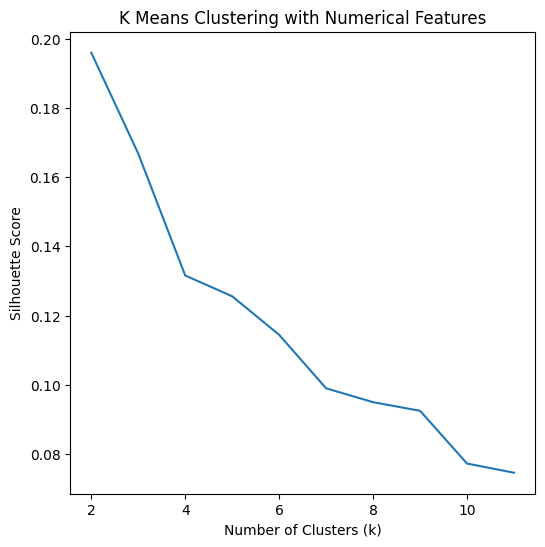

In [161]:
scores = []
for k in tqdm(range(2,12)):
    km = KMeans(n_clusters=k, random_state=seed)
    km.fit(X)
    score = silhouette_score(X, km.labels_, metric='euclidean')
    scores.append(score)

plt.figure(figsize=(6,6))
plt.title('K Means Clustering with Numerical Features')
plt.plot(range(2,12), scores);
plt.xlabel("Number of Clusters (k)");
plt.ylabel("Silhouette Score");

### <center> Using PCA on numerical features </center>

In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
X_scaled = StandardScaler().fit_transform(X)

In [103]:
X_scaled.shape

(23215, 21)

In [104]:
vec, val = np.linalg.eig(X_scaled.T @ X_scaled)

<BarContainer object of 21 artists>

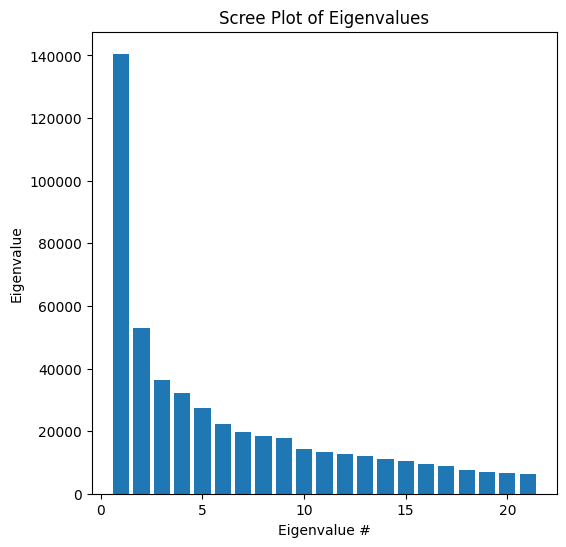

In [105]:
plt.figure(figsize=(6,6))
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Eigenvalue #')
plt.ylabel('Eigenvalue')
plt.bar(np.arange(1, len(vec)+1,1),sorted(vec, reverse=True))

In [109]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4).fit_transform(X_scaled)

In [110]:
colors = plt.cm.coolwarm(pca[:,2])

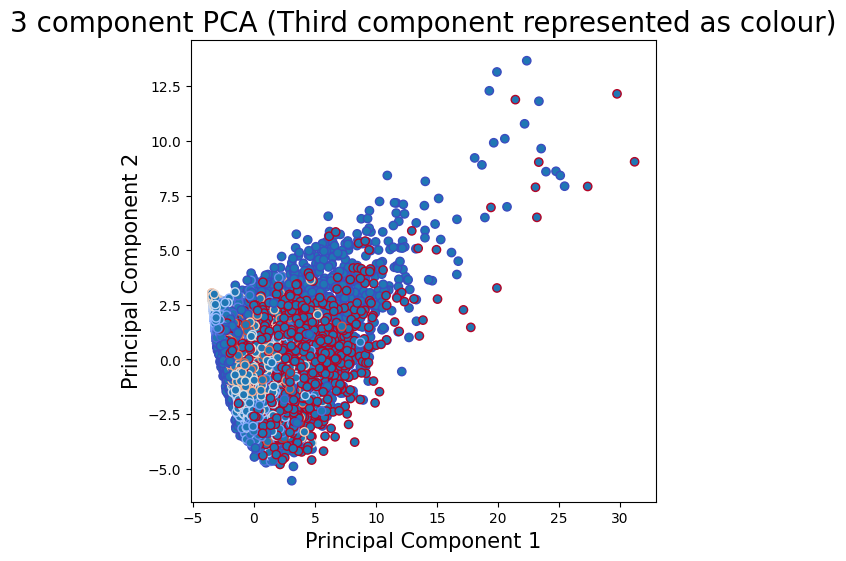

In [162]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA (Third component represented as colour)', fontsize = 20)
ax.scatter(pca[:, 0], pca[:, 1], edgecolors=colors)

In [111]:
X_scaled_2 = pca[:, :2]

100%|███████████████████████████████████████████| 10/10 [00:58<00:00,  5.87s/it]


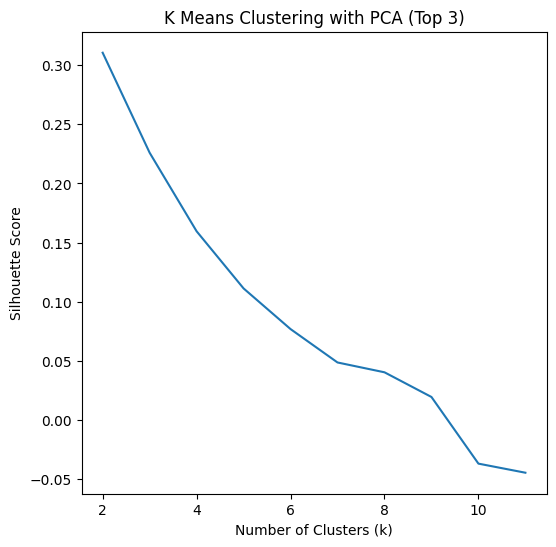

In [163]:
scores = []
for k in tqdm(range(2,12)):
    km = KMeans(n_clusters=k, random_state=seed)
    km.fit(X)
    score = silhouette_score(pca[:, :3], km.labels_, metric='euclidean')
    scores.append(score)

plt.figure(figsize=(6,6))
plt.title('K Means Clustering with PCA (Top 3)')
plt.plot(range(2,12), scores);
plt.xlabel("Number of Clusters (k)");
plt.ylabel("Silhouette Score");

In [113]:
colors = plt.cm.coolwarm(pca[:,3])

## K Prototypes

In [127]:
X = adf[CATEGORICAL_FEATURES + BINARY_FEATURES + NUMERICAL_FEATURES]

In [128]:
missing_vals = pd.DataFrame()
missing_vals['col'] = list(X.columns)
missing_vals['num_missing_vals'] = [X[col].isnull().sum() for col in X.columns]

X = X.drop(list(missing_vals[missing_vals['num_missing_vals'] > 0]['col']), axis=1)
X = X.drop(['CountryClusters'], axis=1)

In [129]:
X.columns[:30]

Index(['CompletedUniDegree', 'UsedPython', 'UsedR', 'UsedSQL', 'UsedPyViz',
       'UsedRViz', 'UsedJSViz', 'UsedSKlearn', 'UsedTFKeras', 'UsedPyTorch',
       'UsedFastAI', 'UsedLinearModels', 'UsedTreeModels', 'UsedGBModels',
       'UsedBayesianModels', 'UsedEvolutionaryModels', 'UsedNNModels',
       'UsedCNNModels', 'UsedGANModels', 'UsedTransformerModels',
       'UsedRNNModels', 'UsedGCP', 'UsedAWS', 'UsedAzure', 'UsedRelationalDBs',
       'UsedNonRelationalDBs', 'UsedPowerBI', 'UsedTableau', 'UsedGPU',
       'UsedE2EPipelineAutomation'],
      dtype='object')

In [165]:
catColumnsPos = [X.columns.get_loc(col) for col in list(X.columns[:31])]

In [164]:
# Choose optimal K using Elbow method
cost = []
for cluster in tqdm(range(2,9)):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = seed)
        kprototype.fit_predict(X, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

 14%|██████▍                                      | 1/7 [01:11<07:10, 71.75s/it]

Cluster initiation: 2


 29%|████████████▌                               | 2/7 [03:21<08:50, 106.11s/it]

Cluster initiation: 3


 43%|██████████████████▊                         | 3/7 [06:58<10:27, 156.78s/it]

Cluster initiation: 4


 57%|█████████████████████████▏                  | 4/7 [12:31<11:18, 226.29s/it]

Cluster initiation: 5


 71%|███████████████████████████████▍            | 5/7 [17:00<08:03, 241.73s/it]

Cluster initiation: 6


 86%|█████████████████████████████████████▋      | 6/7 [27:40<06:16, 376.88s/it]

Cluster initiation: 7


100%|████████████████████████████████████████████| 7/7 [36:20<00:00, 311.44s/it]

Cluster initiation: 8


In [166]:
L1 = cost

In [167]:
L = [744791.280573488,
 678006.6782623926,
 635372.8338874627,
 604516.7016284579,
 580150.1533840792,
 559985.3729226808,
 545307.0813085189,
 533418.556521331]

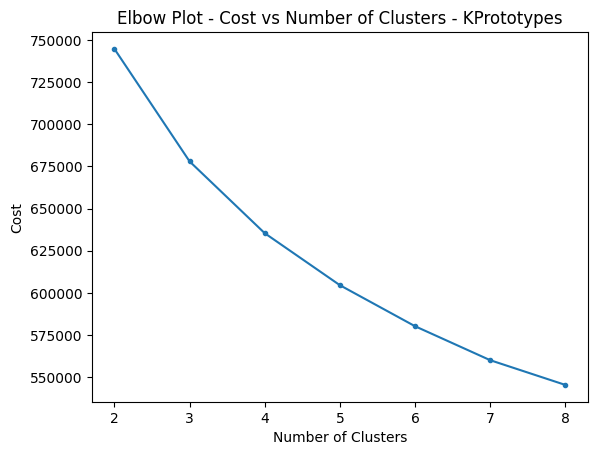

In [169]:
plt.figure()
plt.title('Elbow Plot - Cost vs Number of Clusters - KPrototypes')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.plot(range(2,9), L1, '.-')

In [170]:
kprototype_3clusters = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 1)
kprototype_3clusters.fit_predict(X, categorical = catColumnsPos)

array([0, 2, 1, ..., 2, 1, 1], dtype=uint16)

In [171]:
# Add the cluster to the dataframeX_3cluster = X.copu
X_3cluster = X.copy()

X_3cluster['Cluster Labels'] = kprototype_3clusters.labels_
X_3cluster['Segment'] = X_3cluster['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
X_3cluster['Segment'] = X_3cluster['Segment'].astype('category')
X_3cluster['Segment'] = X_3cluster['Segment'].cat.reorder_categories(['First','Second','Third'])


In [172]:
X_3cluster_v2 = X_3cluster.join(adf['CurrentTitle'])

In [173]:
X_3cluster_v2['isDataScientist'] = X_3cluster_v2['CurrentTitle'] == 'Data Scientist'
X_3cluster_v2['isDataAnalyst'] = X_3cluster_v2['CurrentTitle'] == 'Data Analyst'
X_3cluster_v2['isMLE'] = X_3cluster_v2['CurrentTitle'] == 'Machine Learning Engineer'
X_3cluster_v2['isResearchScientist'] = X_3cluster_v2['CurrentTitle'] == 'Research Scientist'
X_3cluster_v2['isDataEngineer'] = X_3cluster_v2['CurrentTitle'] == 'Data Engineer'
X_3cluster_v2 = X_3cluster_v2.drop(['CurrentTitle'],axis=1)


In [174]:
cols = ['CompletedUniDegree', 'UsedPython', 'UsedR', 'UsedSQL', 'UsedPyViz',
       'UsedRViz', 'UsedJSViz', 'UsedSKlearn', 'UsedTFKeras', 'UsedPyTorch',
       'UsedFastAI', 'UsedLinearModels', 'UsedTreeModels', 'UsedGBModels',
       'UsedBayesianModels', 'UsedEvolutionaryModels', 'UsedNNModels',
       'UsedCNNModels', 'UsedGANModels', 'UsedTransformerModels',
       'UsedRNNModels', 'UsedGCP', 'UsedAWS', 'UsedAzure', 'UsedRelationalDBs',
       'UsedNonRelationalDBs', 'UsedPowerBI', 'UsedTableau', 'UsedGPU',
       'UsedE2EPipelineAutomation', 'Age_categ', 'NumCoursePlatforms',
       'EduOrdinal', 'ProgExpOrdinal', 'NumProgLanguages', 'MLExpOrdinal',
       'NumMLFrameworks', 'NumMLAlgos', 'NumTransferLearning',
       'NumCloudProvidersUsed', 'NumCloudComputeUsed', 'NumCloudStorageUsed',
       'NumBIToolsUsed', 'NumMLaaSToolsUsed', 'NumAutoMLUsed',
       'NumMLDeploymentToolsUsed', 'NumMLMonitoringToolUsed',
       'NumHardwareUsed', 'TPUUsageOrdinal', 'NumDSContentMediaConsumed',
       'NumStepsOfPipelineAutomated','isDataScientist', 'isDataAnalyst', 'isMLE', 'isResearchScientist',
       'isDataEngineer']
agg_dict = {col: 'mean' for col in cols}
agg_dict['Cluster Labels'] = 'count'

In [175]:
X_3cluster_gb = X_3cluster_v2.groupby('Segment').agg(agg_dict).reset_index()

In [176]:
X_3cluster_gb['DataScientistProportion'] = X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isDataScientist']/(sum(X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isDataScientist'])) 
X_3cluster_gb['DataAnalystProportion'] = X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isDataAnalyst']/(sum(X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isDataAnalyst']))
X_3cluster_gb['MLEProportion'] = X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isMLE']/(sum(X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isMLE']))
X_3cluster_gb['ResearchScientistProportion'] = X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isResearchScientist']/(sum(X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isResearchScientist']))
X_3cluster_gb['DataEngineerProportion'] = X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isDataEngineer']/(sum(X_3cluster_gb['Cluster Labels']*X_3cluster_gb['isDataEngineer']))







In [177]:
X_3cluster_gb

,Segment,CompletedUniDegree,UsedPython,UsedR,UsedSQL,UsedPyViz,UsedRViz,UsedJSViz,UsedSKlearn,UsedTFKeras,...,isDataAnalyst,isMLE,isResearchScientist,isDataEngineer,Cluster Labels,DataScientistProportion,DataAnalystProportion,MLEProportion,ResearchScientistProportion,DataEngineerProportion
0,First,0.395324,0.985414,0.366152,0.619691,0.976405,0.405620,0.105749,0.925568,0.865723,...,0.115616,0.199271,0.132990,0.052767,4662,0.283177,0.076130,0.294734,0.187595,0.168840
1,Second,0.095056,0.688818,0.188140,0.384170,0.532363,0.150660,0.013808,0.270620,0.133029,...,0.510048,0.094316,0.115399,0.064480,8111,0.212869,0.584322,0.242703,0.283207,0.358957
2,Third,0.260391,0.926068,0.279448,0.516568,0.893890,0.297836,0.040605,0.774468,0.555353,...,0.230224,0.139628,0.167497,0.065888,10442,0.503953,0.339548,0.462563,0.529198,0.472203


In [316]:
X_3cluster_gb.to_csv('data/3clusterkprototypes_v4.csv', index=False)

In [271]:
X_3cluster['Segment'].value_counts()

Third     10442
Second     8111
First      4662
Name: Segment, dtype: int64

In [245]:
kprototype_4clusters = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 1)
kprototype_4clusters.fit_predict(X, categorical = catColumnsPos)

array([0, 2, 1, ..., 3, 1, 1], dtype=uint16)

In [ ]:
cols = ['CompletedUniDegree', 'UsedPython', 'UsedR', 'UsedSQL', 'UsedPyViz',
       'UsedRViz', 'UsedJSViz', 'UsedSKlearn', 'UsedTFKeras', 'UsedPyTorch',
       'UsedFastAI', 'UsedLinearModels', 'UsedTreeModels', 'UsedGBModels',
       'UsedBayesianModels', 'UsedEvolutionaryModels', 'UsedNNModels',
       'UsedCNNModels', 'UsedGANModels', 'UsedTransformerModels',
       'UsedRNNModels', 'UsedGCP', 'UsedAWS', 'UsedAzure', 'UsedRelationalDBs',
       'UsedNonRelationalDBs', 'UsedPowerBI', 'UsedTableau', 'UsedGPU',
       'UsedE2EPipelineAutomation', 'Age_categ', 'NumCoursePlatforms',
       'EduOrdinal', 'ProgExpOrdinal', 'NumProgLanguages', 'MLExpOrdinal',
       'NumMLFrameworks', 'NumMLAlgos', 'NumTransferLearning',
       'NumCloudProvidersUsed', 'NumCloudComputeUsed', 'NumCloudStorageUsed',
       'NumBIToolsUsed', 'NumMLaaSToolsUsed', 'NumAutoMLUsed',
       'NumMLDeploymentToolsUsed', 'NumMLMonitoringToolUsed',
       'NumHardwareUsed', 'TPUUsageOrdinal', 'NumDSContentMediaConsumed',
       'NumStepsOfPipelineAutomated','isDataScientist', 'isDataAnalyst', 'isMLE', 'isResearchScientist',
       'isDataEngineer']
agg_dict = {col: 'mean' for col in cols}
agg_dict['Cluster Labels'] = 'count'

In [319]:
# Add the cluster to the dataframeX_4cluster = X.copu
X_4cluster = X.copy()

X_4cluster['Cluster Labels'] = kprototype_4clusters.labels_
X_4cluster['Segment'] = X_4cluster['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3:'Fourth'})
# Order the cluster
X_4cluster['Segment'] = X_4cluster['Segment'].astype('category')
X_4cluster['Segment'] = X_4cluster['Segment'].cat.reorder_categories(['First','Second','Third','Fourth'])

X_4cluster_v2 = X_4cluster.join(adf['CurrentTitle'])
X_4cluster_v2['isDataScientist'] = X_4cluster_v2['CurrentTitle'] == 'Data Scientist'
X_4cluster_v2['isDataAnalyst'] = X_4cluster_v2['CurrentTitle'] == 'Data Analyst'
X_4cluster_v2['isMLE'] = X_4cluster_v2['CurrentTitle'] == 'Machine Learning Engineer'
X_4cluster_v2['isResearchScientist'] = X_4cluster_v2['CurrentTitle'] == 'Research Scientist'
X_4cluster_v2['isDataEngineer'] = X_4cluster_v2['CurrentTitle'] == 'Data Engineer'
X_4cluster_v2 = X_4cluster_v2.drop(['CurrentTitle'],axis=1)

X_4cluster_gb = X_4cluster_v2.groupby('Segment').agg(agg_dict).reset_index()

X_4cluster_gb['DataScientistProportion'] = X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isDataScientist']/(sum(X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isDataScientist'])) 
X_4cluster_gb['DataAnalystProportion'] = X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isDataAnalyst']/(sum(X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isDataAnalyst']))
X_4cluster_gb['MLEProportion'] = X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isMLE']/(sum(X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isMLE']))
X_4cluster_gb['ResearchScientistProportion'] = X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isResearchScientist']/(sum(X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isResearchScientist']))
X_4cluster_gb['DataEngineerProportion'] = X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isDataEngineer']/(sum(X_4cluster_gb['Cluster Labels']*X_4cluster_gb['isDataEngineer']))





In [320]:
X_4cluster_gb

,Segment,CompletedUniDegree,UsedPython,UsedR,UsedSQL,UsedPyViz,UsedRViz,UsedJSViz,UsedSKlearn,UsedTFKeras,...,isDataAnalyst,isMLE,isResearchScientist,isDataEngineer,Cluster Labels,DataScientistProportion,DataAnalystProportion,MLEProportion,ResearchScientistProportion,DataEngineerProportion
0,First,0.407767,0.988072,0.378086,0.654369,0.980860,0.427462,0.118724,0.936477,0.885992,...,0.112067,0.205825,0.116782,0.057143,3605,0.222844,0.057062,0.235406,0.127383,0.141386
1,Second,0.081124,0.650709,0.184320,0.371076,0.471836,0.141178,0.013186,0.198509,0.090010,...,0.518418,0.090583,0.121112,0.066504,6977,0.172607,0.510876,0.200508,0.255673,0.318463
2,Third,0.275313,0.906107,0.324249,0.471255,0.863736,0.317088,0.051920,0.736821,0.528944,...,0.117366,0.141237,0.240103,0.044162,5027,0.279528,0.083333,0.225254,0.365204,0.152368
3,Fourth,0.251512,0.945832,0.246121,0.536682,0.924796,0.276492,0.032606,0.806206,0.582829,...,0.324612,0.140415,0.109387,0.074283,7606,0.325021,0.348729,0.338832,0.251740,0.387783


In [259]:
X_4cluster_gb.to_csv('data/4clusterkprototypes.csv', index=False)

In [260]:
X_4cluster['Segment'].value_counts()

Fourth    7606
Second    6977
Third     5027
First     3605
Name: Segment, dtype: int64

In [322]:
kprototype_5clusters = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 1)
kprototype_5clusters.fit_predict(X, categorical = catColumnsPos)

array([4, 2, 1, ..., 3, 1, 1], dtype=uint16)

In [327]:
# Add the cluster to the dataframeX_5cluster = X.copu
X_5cluster = X.copy()

X_5cluster['Cluster Labels'] = kprototype_5clusters.labels_
X_5cluster['Segment'] = X_5cluster['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'})
# Order the cluster
X_5cluster['Segment'] = X_5cluster['Segment'].astype('category')
X_5cluster['Segment'] = X_5cluster['Segment'].cat.reorder_categories(['First','Second','Third','Fourth', 'Fifth'])

X_5cluster_v2 = X_5cluster.join(adf['CurrentTitle'])
X_5cluster_v2['isDataScientist'] = X_5cluster_v2['CurrentTitle'] == 'Data Scientist'
X_5cluster_v2['isDataAnalyst'] = X_5cluster_v2['CurrentTitle'] == 'Data Analyst'
X_5cluster_v2['isMLE'] = X_5cluster_v2['CurrentTitle'] == 'Machine Learning Engineer'
X_5cluster_v2['isResearchScientist'] = X_5cluster_v2['CurrentTitle'] == 'Research Scientist'
X_5cluster_v2['isDataEngineer'] = X_5cluster_v2['CurrentTitle'] == 'Data Engineer'
X_5cluster_v2 = X_5cluster_v2.drop(['CurrentTitle'],axis=1)

X_5cluster_gb = X_5cluster_v2.groupby('Segment').agg(agg_dict).reset_index()

X_5cluster_gb['DataScientistProportion'] = X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isDataScientist']/(sum(X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isDataScientist'])) 
X_5cluster_gb['DataAnalystProportion'] = X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isDataAnalyst']/(sum(X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isDataAnalyst']))
X_5cluster_gb['MLEProportion'] = X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isMLE']/(sum(X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isMLE']))
X_5cluster_gb['ResearchScientistProportion'] = X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isResearchScientist']/(sum(X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isResearchScientist']))
X_5cluster_gb['DataEngineerProportion'] = X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isDataEngineer']/(sum(X_5cluster_gb['Cluster Labels']*X_5cluster_gb['isDataEngineer']))




In [335]:
X_5cluster_gb.to_csv('data/5clusterprototypes.csv')

In [336]:
X_4cluster_gb.to_csv('data/4clusterprototypes.csv')

In [334]:
X_3cluster_gb.to_csv('data/3clusterprototypes.csv')

### Visualizing Results

In [140]:
cat_cols_to_visualize = ['CompletedUniDegree', 'UsedPython', 'UsedR', 'UsedSQL',
       'UsedPyViz', 'UsedRViz', 'UsedJSViz', 'UsedSKlearn', 'UsedTFKeras',
       'UsedPyTorch', 'UsedFastAI', 'UsedLinearModels', 'UsedTreeModels',
       'UsedGBModels', 'UsedBayesianModels', 'UsedEvolutionaryModels',
       'UsedNNModels', 'UsedCNNModels', 'UsedGANModels',
       'UsedTransformerModels', 'UsedRNNModels', 'UsedGCP', 'UsedAWS',
       'UsedAzure', 'UsedRelationalDBs', 'UsedNonRelationalDBs', 'UsedPowerBI',
       'UsedTableau', 'UsedGPU', 'UsedE2EPipelineAutomation']
                         
                         
num_cols_to_visualize = ['Age_categ',
       'NumCoursePlatforms',,
       'NumProgLanguages', 'MLExpOrdinal', 'NumMLFrameworks', 'NumMLAlgos',
       'NumTransferLearning', 'NumCloudProvidersUsed', 'NumCloudComputeUsed',
       'NumCloudStorageUsed', 'NumBIToolsUsed', 'NumMLaaSToolsUsed',
       'NumAutoMLUsed', 'NumMLDeploymentToolsUsed', 'NumMLMonitoringToolUsed',
       'NumHardwareUsed', 'TPUUsageOrdinal', 'NumDSContentMediaConsumed', 'NumStepsOfPipelineAutomated']


occupation_cols = ['isDataScientist', 'isDataAnalyst',
       'isMLE', 'isResearchScientist', 'isDataEngineer',
       'DataScientistProportion', 'DataAnalystProportion', 'MLEProportion',
       'ResearchScientistProportion', 'DataEngineerProportion']

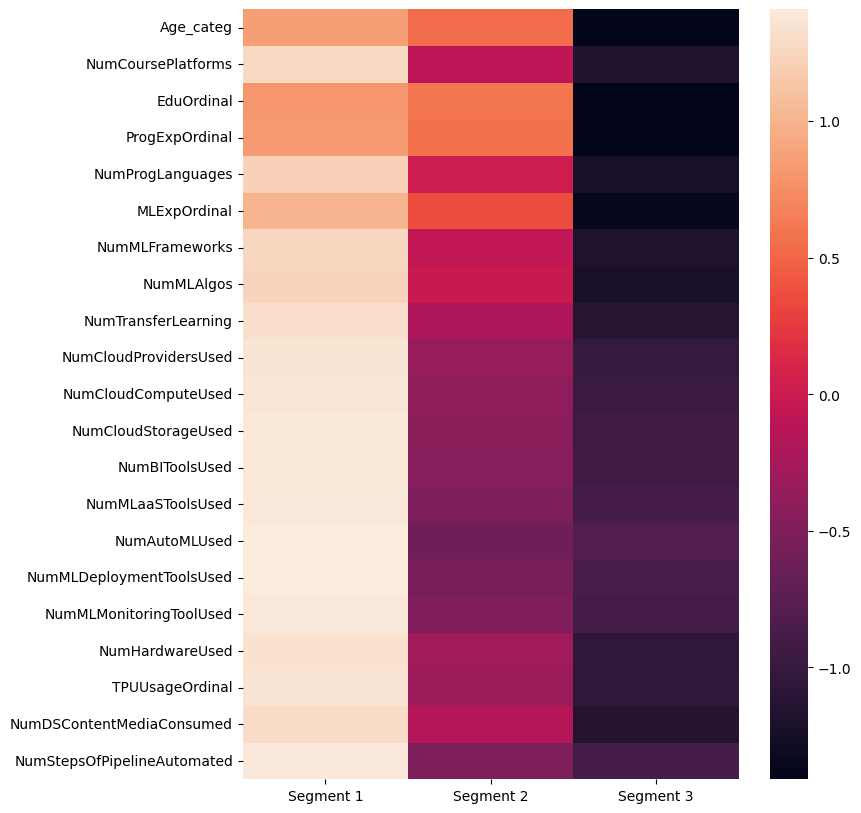

In [201]:
cluster3_numfeatures = X_3cluster_gb[num_cols_to_visualize].copy()
s = StandardScaler()
cluster3_numfeatures = pd.DataFrame(s.fit_transform(cluster3_numfeatures), columns=num_cols_to_visualize)

plt.figure(figsize=(8,10))
c3nf = cluster3_numfeatures.T[[0,2,1]]
c3nf.columns = ['Segment 1', 'Segment 2', 'Segment 3']
sns.heatmap(c3nf)
plt.show()

In [199]:
cluster3_numfeatures.T[[0,2,1]]

,0,2,1
EduOrdinal,0.803871,0.605707,-1.409578
ProgExpOrdinal,0.834365,0.571693,-1.406059
NumMLFrameworks,1.259209,-0.072116,-1.187093
NumDSContentMediaConsumed,1.293414,-0.151418,-1.141996
NumMLAlgos,1.234903,-0.020577,-1.214327


### Picking features to showcase in report

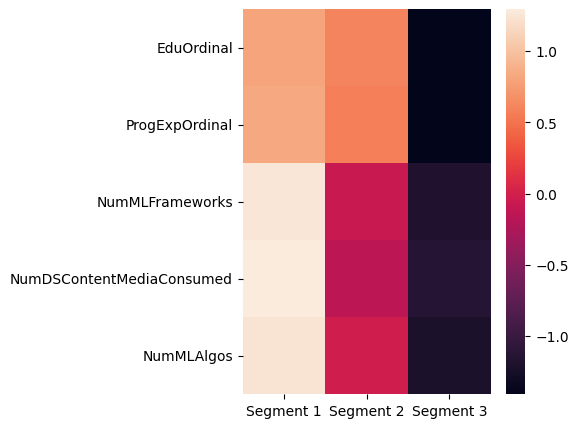

In [203]:
imp_num_calls = ['EduOrdinal', 'ProgExpOrdinal', 'NumMLFrameworks', 'NumDSContentMediaConsumed', 'NumMLAlgos']
cluster3_numfeatures = X_3cluster_gb[imp_num_calls].copy()
s = StandardScaler()
cluster3_numfeatures = pd.DataFrame(s.fit_transform(cluster3_numfeatures), columns=imp_num_calls)

plt.figure(figsize=(4,5))
c3nf = cluster3_numfeatures.T[[0,2,1]]
c3nf.columns = ['Segment 1', 'Segment 2', 'Segment 3']
sns.heatmap(c3nf)
plt.show()

In [179]:
x3gb = X_3cluster_gb[cat_cols_to_visualize].copy()
for col in X_3cluster_gb[cat_cols_to_visualize].columns:
    x3gb[col] = x3gb[col]/X_3cluster_v2[col].mean()

In [180]:
X_3cluster_gb[cat_cols_to_visualize[10:20]]

,UsedFastAI,UsedLinearModels,UsedTreeModels,UsedGBModels,UsedBayesianModels,UsedEvolutionaryModels,UsedNNModels,UsedCNNModels,UsedGANModels,UsedTransformerModels
0,0.149936,0.872801,0.848563,0.781853,0.452381,0.143072,0.542900,0.735521,0.216216,0.386958
1,0.003945,0.295031,0.203797,0.065590,0.051165,0.007274,0.023548,0.058069,0.006904,0.009247
2,0.028060,0.763838,0.677361,0.451255,0.245930,0.045202,0.220456,0.369948,0.047213,0.100747


In [181]:
x3gb[cat_cols_to_visualize[10:20]]

,UsedFastAI,UsedLinearModels,UsedTreeModels,UsedGBModels,UsedBayesianModels,UsedEvolutionaryModels,UsedNNModels,UsedCNNModels,UsedGANModels,UsedTransformerModels
0,3.399176,1.403386,1.553334,2.041931,2.062456,2.772461,2.508643,2.199552,3.223802,3.064906
1,0.089443,0.474384,0.373061,0.171298,0.233267,0.140958,0.108812,0.173654,0.102942,0.073239
2,0.636140,1.228183,1.239941,1.178521,1.121222,0.875932,1.018687,1.106318,0.703952,0.797967


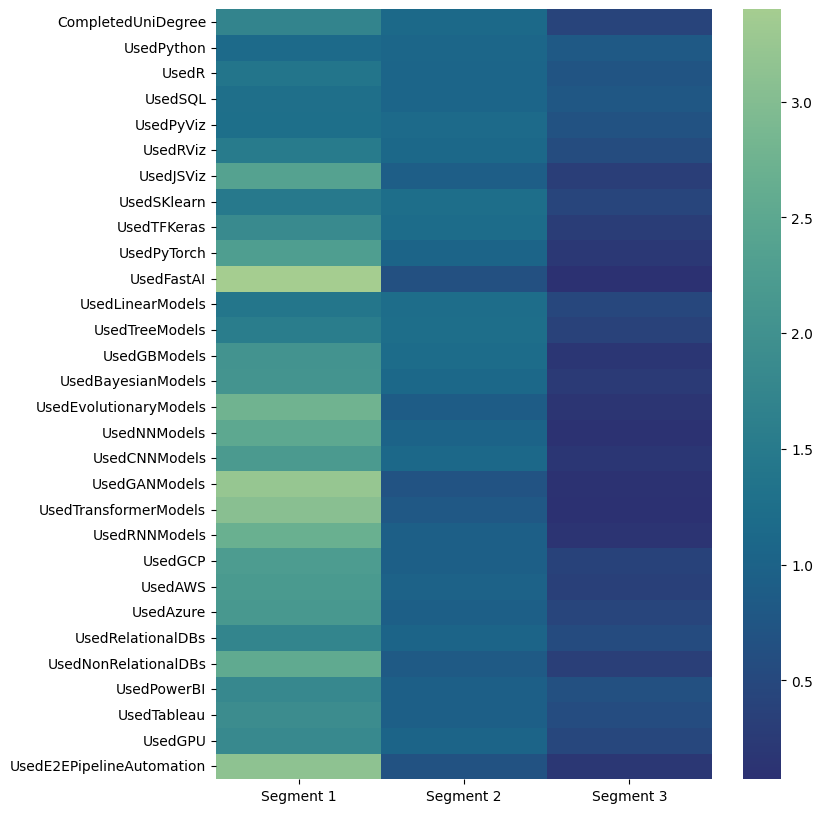

In [204]:
plt.figure(figsize=(8,10))
c3cf = x3gb[cat_cols_to_visualize].T[[0,2,1]]
c3cf.columns = ['Segment 1', 'Segment 2', 'Segment 3']
sns.heatmap(c3cf, cmap="crest_r")
plt.show()

### Picking features to showcase in report

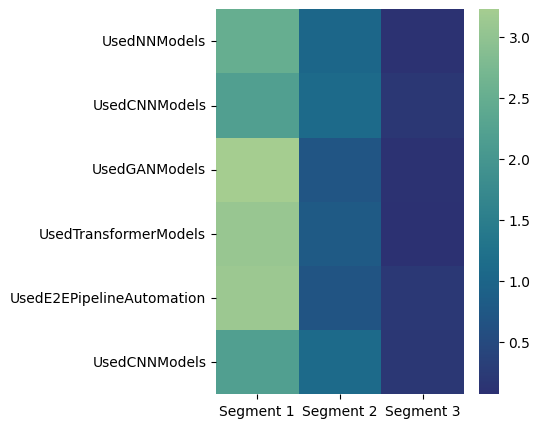

In [207]:
imp_cat_cols = ['UsedNNModels',  'UsedCNNModels', 'UsedGANModels', 'UsedTransformerModels', 'UsedE2EPipelineAutomation', 'UsedCNNModels']
plt.figure(figsize=(4,5))
c3cf = x3gb[imp_cat_cols].T[[0,2,1]]
c3cf.columns = ['Segment 1', 'Segment 2', 'Segment 3']
sns.heatmap(c3cf, cmap="crest_r")
plt.show()

In [188]:
X_3cluster['Country'] = adf['Country']
X_3cluster['PID'] = adf['PID']
USA_salaries_clustered = X_3cluster[X_3cluster['Country'] == 'United States of America'].merge(survey_df[['AnnualComp(USD)', 'PID']], on='PID').dropna().drop_duplicates()

### Salary Analysis

In [189]:
USA_salaries_clustered['AnnualComp(USD)'].value_counts().to_dict()
salary_map = {'100,000-124,999': 'c. 100K+',
 '150,000-199,999': 'd. 150K+',
 '125,000-149,999': 'c. 100K+',
 '200,000-249,999': 'e. 200K+',
 '90,000-99,999': 'b. 50K+',
 '70,000-79,999': 'b. 50K+',
 '80,000-89,999': 'b. 50K+',
 '$0-999': 'a. 0K+',
 '60,000-69,999': 'b. 50K+',
 '50,000-59,999': 'b. 50K+',
 '250,000-299,999': 'e. 200K+',
 '40,000-49,999': 'a. 0K+',
 '300,000-499,999': 'b. 50K+',
 '30,000-39,999': 'a. 0K+',
 '25,000-29,999': 'a. 0K+',
 '20,000-24,999': 'a. 0K+',
 '300,000-500,000': 'f. 300K+',
 '10,000-14,999': 'a. 0K+',
 '$500,000-999,999': 'g. 500K+',
 '5,000-7,499': 'a. 0K+',
 '7,500-9,999': 'a. 0K+',
 '>$1,000,000': 'g. 500K+',
 '15,000-19,999': 'a. 0K+',
 '1,000-1,999': 'a. 0K+',
 '2,000-2,999': 'a. 0K+',
 '4,000-4,999': 'a. 0K+',
 '> $500,000': 'g. 500K+',
 '3,000-3,999': 'a. 0K+'}
USA_salaries_clustered['AnnualComp(USD)'] = USA_salaries_clustered['AnnualComp(USD)'].apply(lambda x: salary_map[x])

In [198]:
USA_Salaries_segment = pd.DataFrame(USA_salaries_clustered['Segment']).join(pd.get_dummies(USA_salaries_clustered[['AnnualComp(USD)']]))
a = USA_Salaries_segment.groupby('Segment').agg({col: 'mean' for col in USA_Salaries_segment.columns[1:]}).reset_index()
a.columns = ['Segment', 'a. 0K+',
 'b. 50K+',
 'c. 100K+',
 'd. 150K+',
 'e. 200K+',
 'f. 300K+',
 'g. 500K+']

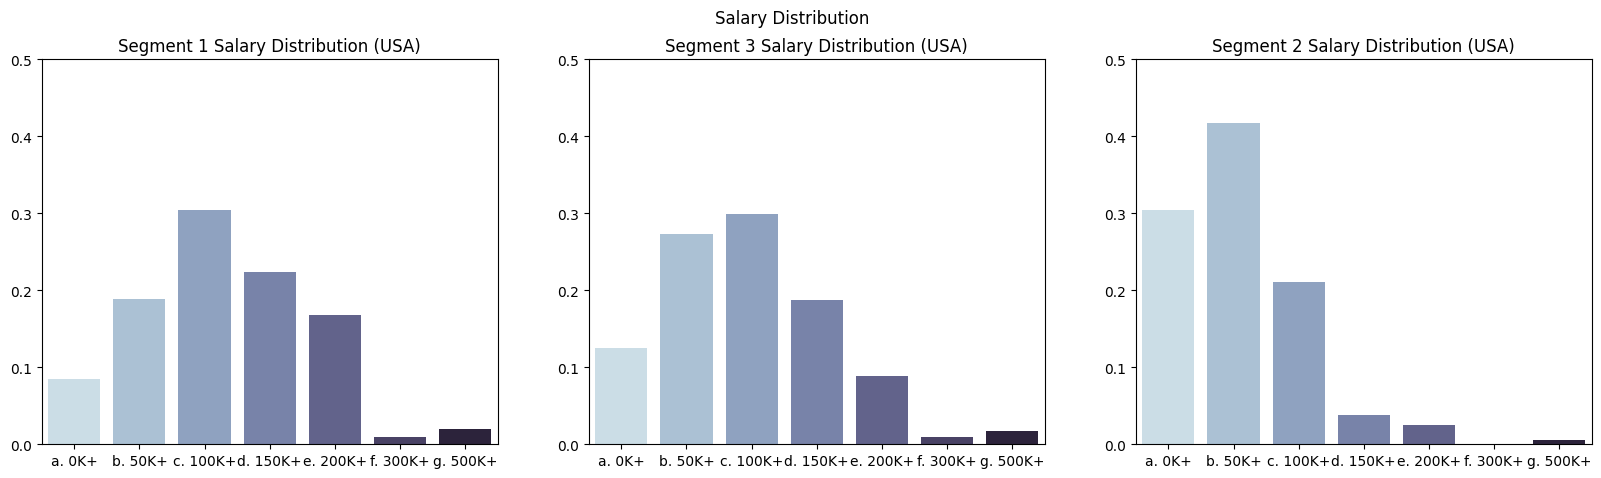

In [191]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Salary Distribution')

axes[0].title.set_text('Segment 1 Salary Distribution (USA)')
axes[1].title.set_text('Segment 3 Salary Distribution (USA)')
axes[2].title.set_text('Segment 2 Salary Distribution (USA)')

plt.setp(axes, yticks=np.arange(0,0.6,0.1), ylim = (0, 0.5))

# plt.title('Segment 1 Salary Distribution (USA)')
sns.barplot(ax=axes[0], data=a[a['Segment'] == 'First'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[1], data=a[a['Segment'] == 'Third'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[2], data=a[a['Segment'] == 'Second'], palette="ch:s=.25,rot=-.25")

plt.show()

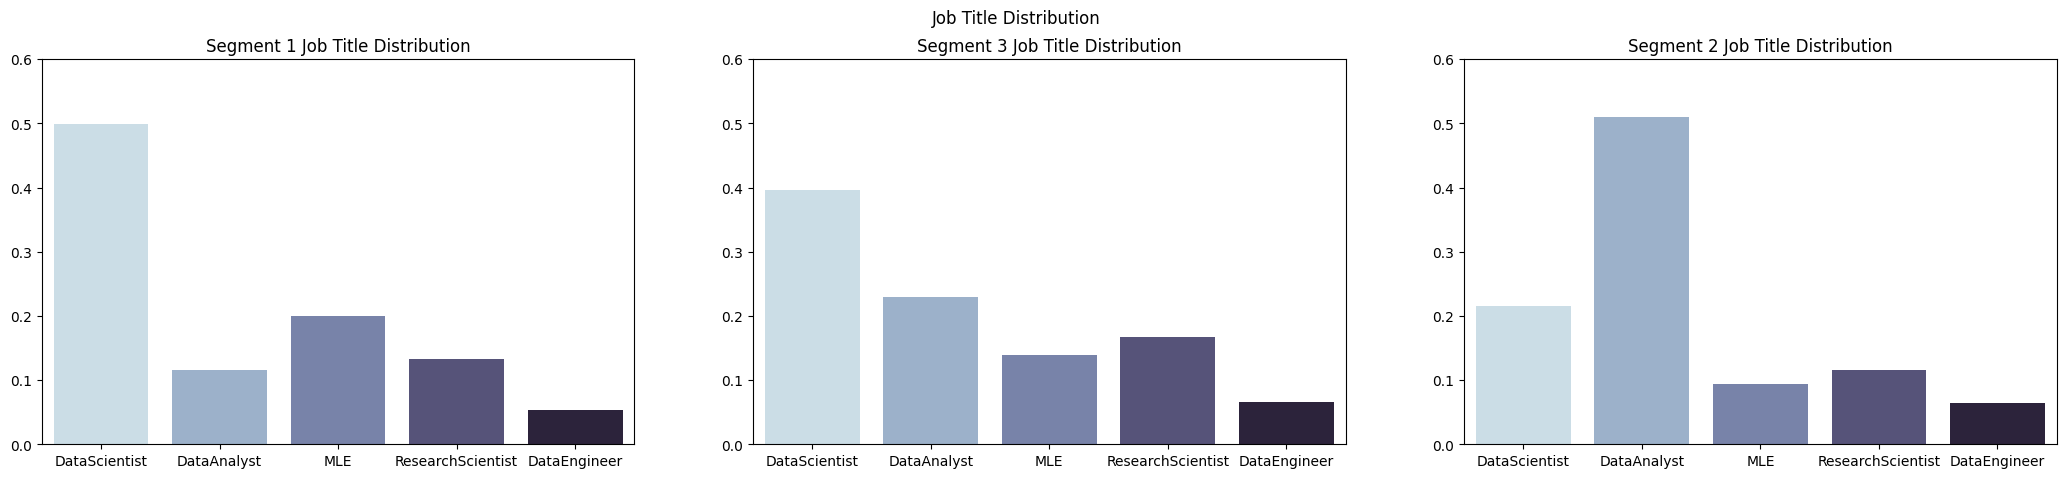

In [215]:
title_cols = ['Segment', 'isDataScientist', 'isDataAnalyst', 'isMLE', 'isResearchScientist', 'isDataEngineer']
a = X_3cluster_gb[title_cols]
a.columns = ['Segment', 'DataScientist', 'DataAnalyst', 'MLE', 'ResearchScientist', 'DataEngineer']

fig, axes = plt.subplots(1, 3, figsize=(26, 5))
fig.suptitle('Job Title Distribution')

axes[0].title.set_text('Segment 1 Job Title Distribution')
axes[1].title.set_text('Segment 3 Job Title Distribution')
axes[2].title.set_text('Segment 2 Job Title Distribution')

plt.setp(axes, yticks=np.arange(0,0.7,0.1), ylim = (0, 0.6))

# plt.title('Segment 1 Salary Distribution (USA)')
sns.barplot(ax=axes[0], data=a[a['Segment'] == 'First'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[1], data=a[a['Segment'] == 'Third'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[2], data=a[a['Segment'] == 'Second'], palette="ch:s=.25,rot=-.25")

plt.show()

/var/folders/07/r04lbdjd0vj2ps53pqkc0b040000gn/T/ipykernel_1115/2016857516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['Segment'] = a['Segment'].cat.reorder_categories(['First','Third','Second'])
/var/folders/07/r04lbdjd0vj2ps53pqkc0b040000gn/T/ipykernel_1115/2016857516.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['Segment'] = a['Segment'].map({'First':'First', 'Second':'Third', 'Third': 'Second'})


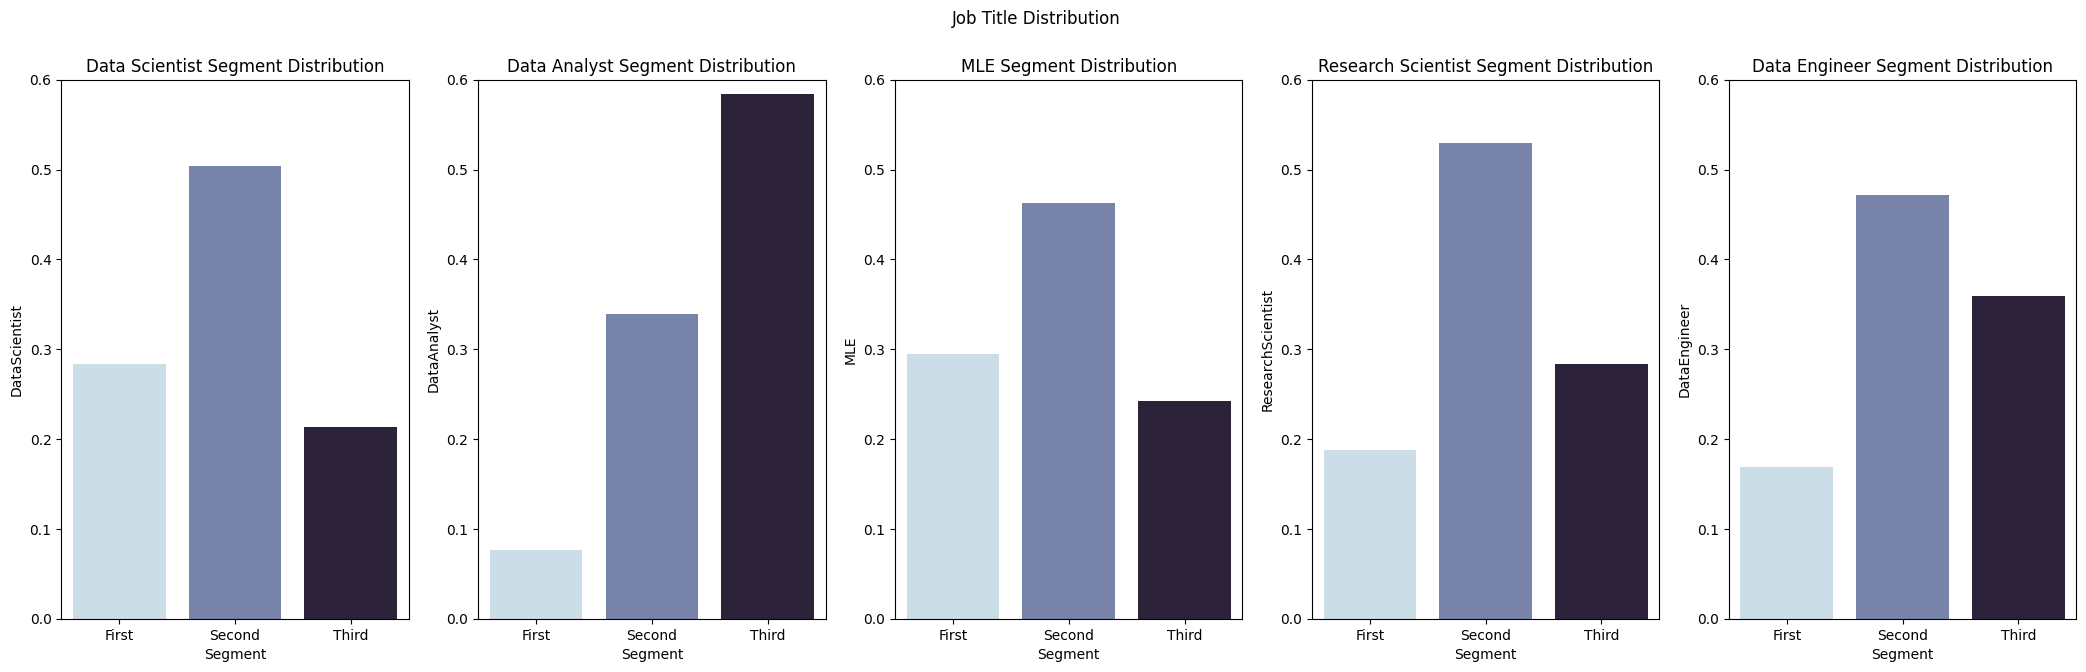

In [229]:
title_cols = ['Segment', 'DataScientistProportion', 'DataAnalystProportion', 'MLEProportion',
       'ResearchScientistProportion', 'DataEngineerProportion']
a = X_3cluster_gb[title_cols]
a.columns = ['Segment', 'DataScientist', 'DataAnalyst', 'MLE', 'ResearchScientist', 'DataEngineer']

a['Segment'] = a['Segment'].cat.reorder_categories(['First','Third','Second'])
a['Segment'] = a['Segment'].map({'First':'First', 'Second':'Third', 'Third': 'Second'})

fig, axes = plt.subplots(1, 5, figsize=(26, 7))
fig.suptitle('Job Title Distribution')

axes[0].title.set_text('Data Scientist Segment Distribution')
axes[1].title.set_text('Data Analyst Segment Distribution')
axes[2].title.set_text('MLE Segment Distribution')
axes[3].title.set_text('Research Scientist Segment Distribution')
axes[4].title.set_text('Data Engineer Segment Distribution')

plt.setp(axes, yticks=np.arange(0,0.7,0.1), ylim = (0, 0.6))

# plt.title('Segment 1 Salary Distribution (USA)')
sns.barplot(ax=axes[0], data=a[a['Segment'] == 'Second'], x=a['Segment'], y=a['DataScientist'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[1], data=a[a['Segment'] == 'Second'], x=a['Segment'], y=a['DataAnalyst'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[2], data=a[a['Segment'] == 'Second'], x=a['Segment'], y=a['MLE'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[3], data=a[a['Segment'] == 'Second'], x=a['Segment'], y=a['ResearchScientist'], palette="ch:s=.25,rot=-.25")
sns.barplot(ax=axes[4], data=a[a['Segment'] == 'Second'], x=a['Segment'], y=a['DataEngineer'], palette="ch:s=.25,rot=-.25")


plt.show()

In [218]:
a

,Segment,DataScientist,DataAnalyst,MLE,ResearchScientist,DataEngineer
0,First,0.283177,0.076130,0.294734,0.187595,0.168840
1,Second,0.212869,0.584322,0.242703,0.283207,0.358957
2,Third,0.503953,0.339548,0.462563,0.529198,0.472203
